In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.nn import ReLU,Sigmoid,Linear,Sequential,BCELoss
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from  skimage.transform import resize

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive

# This will prompt you to authenticate and grant access to your Google Drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/archive (3).zip'

Archive:  /content/drive/MyDrive/archive (3).zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **Creating a dataframe with names of files and category**

In [ ]:
def list_creation(location):
    list=[] #List to store the normal file names
    for dirname, _, filenames in os.walk(location):
        for filename in filenames:
            list.append(os.path.join(filename))
    return list

def dataframe(list,value):
    df=pd.DataFrame(list, columns=['image'])
    df['category']=value
    return df

In [ ]:
#Create all the lists
normal_location='/content/chest_xray/train/NORMAL'
pneumonia_location='/content/chest_xray/train/PNEUMONIA'
val_normal_location='/content/chest_xray/val/NORMAL'
val_pneumonia_location='/content/chest_xray/val/PNEUMONIA'
normal_list=list_creation(normal_location)
pneumonia_list=list_creation(pneumonia_location)
val_normal_list=list_creation(val_normal_location)
val_pneumonia_list=list_creation(val_pneumonia_location)

In [ ]:
#Let's check the pneumonia_list
print(len(normal_list))
print(len(pneumonia_list))
print(len(val_normal_list))
print(len(val_pneumonia_list))

In [ ]:
#Get Dataframes
df_normal=dataframe(normal_list,0)
df_pneum=dataframe(pneumonia_list,1)
df_val_norm=dataframe(val_normal_list,0)
df_val_pneum=dataframe(val_pneumonia_list,1)
print(df_normal.shape)
print(df_pneum.shape)
print(df_val_norm.shape)
print(df_val_pneum.shape)

In [ ]:
#Create a train datafram and val dataframe
df = pd.concat([df_normal, df_pneum], ignore_index=True)
df_val = pd.concat([df_val_norm, df_val_pneum], ignore_index=True)

In [17]:
print(df.shape), print(df_val.shape)

(5216, 2)
(16, 2)


(None, None)

## Let's read the images

In [ ]:
#Let's check the max and min
print(plt.imread('/content/chest_xray/train/NORMAL/IM-0218-0001.jpeg').min())
print(plt.imread('/content/chest_xray/train/NORMAL/IM-0218-0001.jpeg').max())

In [18]:
X_train=[]
for index, row in df.iterrows():
    if row['category']==0:
        img=plt.imread(normal_location+'/'+row['image'])
        img=img/255
    else:
        img=plt.imread(pneumonia_location+'/'+row['image'])
    X_train.append(img)

X_test=[]
for index, row in df_val.iterrows():
    if row['category']==0:
        img=plt.imread(val_normal_location+'/'+row['image'])
        img=img/255
    else:
        img=plt.imread(val_pneumonia_location+'/'+row['image'])
        img=img/255
    X_test.append(img)

In [19]:
len(X_test)

16

In [20]:
len(X_train),len(X_test)

(5216, 16)

In [21]:
# Let's check the size of images
X_train[0].shape,X_train[1].shape

((1086, 1414), (1510, 1596))

In [22]:
# Let's chek the max and min in images
X_train[0].max(),X_train[0].min()

(1.0, 0.0)

In [23]:
X_train[0]

array([[0.30196078, 0.29411765, 0.29803922, ..., 0.        , 0.        ,
        0.        ],
       [0.29019608, 0.27843137, 0.28627451, ..., 0.        , 0.        ,
        0.        ],
       [0.29019608, 0.27058824, 0.26666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## **Image size is different**

In [24]:
list_size_chg_train=[]
ct=0
for i in range(0,len(X_train)):
  if(len(X_train[i].shape)>2):
    ct+=1
    list_size_chg_train.append(i)
print(ct)

283


In [25]:
#Let's check in test
list_size_chg_test=[]
ct=0
for i in range(0,len(X_test)):
  if(len(X_test[i].shape)>2):
    ct+=1
    list_size_chg_test.append(i)
print(ct)

0


In [26]:
#So only in the train set we have 3 channels, let's exclude those images

In [27]:
#Remove the non standrd channels from Train dataframe
df=df.loc[~df.index.isin(list_size_chg_train)]
df.shape

(4933, 2)

In [28]:
df.reset_index(drop=True,inplace=True)
df.head()

,image,category
0,IM-0644-0001.jpeg,0
1,NORMAL2-IM-1220-0001.jpeg,0
2,IM-0364-0001.jpeg,0
3,IM-0261-0001.jpeg,0
4,NORMAL2-IM-0395-0001.jpeg,0


In [29]:
#Let's create the X_train again
X_train=[]
for index, row in df.iterrows():
    if row['category']==0:
        img=plt.imread(normal_location+'/'+row['image'])
        img=img/255
    else:
        img=plt.imread(pneumonia_location+'/'+row['image'])
    X_train.append(img)

In [30]:
X_train[0]

array([[0.30196078, 0.29411765, 0.29803922, ..., 0.        , 0.        ,
        0.        ],
       [0.29019608, 0.27843137, 0.28627451, ..., 0.        , 0.        ,
        0.        ],
       [0.29019608, 0.27058824, 0.26666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

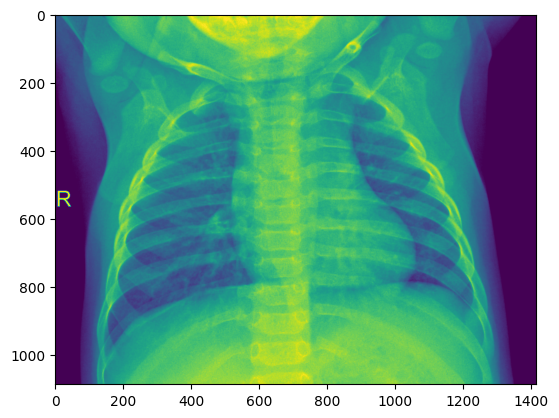

In [31]:
plt.imshow(X_train[0])

# **Let's resize all the images**

In [32]:
# Let's resize
for i in range(0,len(X_train)):
  X_train[i]=resize(X_train[i],(224,224))


In [33]:
for i in range(0,len(X_test)):
  X_test[i]=resize(X_test[i],(224,224))

In [34]:
X_train=np.array(X_train)
X_test=np.array(X_test)

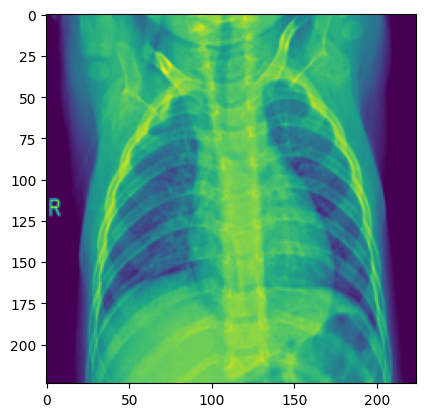

In [35]:
plt.imshow(X_train[2])

In [36]:
y_train=df['category']
y_test=df_val['category']

In [37]:
#Save the image arrays on Google drive

save_path = '/content/drive/My Drive/X_train.npz'
np.savez_compressed(save_path, image_array=X_train)

save_path = '/content/drive/My Drive/X_test.npz'
np.savez_compressed(save_path, image_array=X_test)

save_path = '/content/drive/My Drive/y_train.npz'
np.savez_compressed(save_path, image_array=y_train)

save_path = '/content/drive/My Drive/y_test.npz'
np.savez_compressed(save_path, image_array=y_test)

In [ ]:
# #Retrieve the X_train and X_test
# # Load the .npz file
# save_path_train = '/content/drive/My Drive/X_train.npz'
# save_path_test = '/content/drive/My Drive/X_test.npz'


# # Retrieve the array
# loaded_data = np.load(save_path_train)
# X_train = loaded_data['image_array']

# loaded_data = np.load(save_path_test)
# X_test = loaded_data['image_array']


In [38]:
X_train.shape

(4933, 224, 224)

In [39]:
X_train[0]

array([[0.28486615, 0.29271668, 0.39275794, ..., 0.        , 0.        ,
        0.        ],
       [0.27734265, 0.27901834, 0.31539812, ..., 0.        , 0.        ,
        0.        ],
       [0.27409193, 0.28145523, 0.28549678, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

##Let's move towards refining data so that we can feed to torch##

In [40]:
X_train_channel = np.expand_dims(X_train, axis=1)
X_test_channel= np.expand_dims(X_test, axis=1)

In [41]:
X_train_channel.shape

(4933, 1, 224, 224)

In [42]:
X_train_torch=torch.FloatTensor(X_train_channel)
X_test_torch=torch.FloatTensor(X_test_channel)

# **Load weights of pretrained model**

In [43]:
vgg16_model=vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 237MB/s]


In [44]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
for param in vgg16_model.parameters():
  param.requires_grad=False

In [46]:
#modifying the train and test for 3 channels because vgg16 takes 3 channesl
X_train_torch=X_train_torch.repeat(1, 3, 1, 1)
X_test_torch=X_test_torch.repeat(1, 3, 1, 1)

In [ ]:
X_train_torch

In [47]:
#understanding the output of vgg
input=X_train_torch[:2]
output=vgg16_model.features(input)
output.shape

torch.Size([2, 512, 7, 7])

In [48]:
if torch.cuda.is_available():
  vgg16_model=vgg16_model.cuda()

**Start the modelling**

In [49]:
def feature_extraction(array):

  features=[]
  batch_size=32
  indices=torch.arange(len(array))

  vgg16_model.eval()

  #feature extractionA
  with torch.no_grad():
    for i in tqdm(range(0,len(array),batch_size)):
      ind=indices[i:i+batch_size]
      #Creating batches
      batch_X=array[ind]
      if torch.cuda.is_available():
        batch_X=batch_X.cuda()
      #Getting features
      batch_features=vgg16_model.features(batch_X)
      batch_features=batch_features.data.cpu().numpy()

      features.append(batch_features)

# Since data is in batches we will arrange them properly now
  features=np.concatenate(features,axis=0)
  return(features)


In [50]:
X_train_final=feature_extraction(X_train_torch)

100%|██████████| 155/155 [01:15<00:00,  2.04it/s]


In [51]:
X_test_final=feature_extraction(X_test_torch)

100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


In [52]:
X_train_final.shape,X_test_final.shape,y_train.shape,y_test.shape

((4933, 512, 7, 7), (16, 512, 7, 7), (4933,), (16,))

In [53]:
X_train_final=X_train_final.reshape(len(X_train_final),-1)
X_test_final=X_test_final.reshape(len(X_test_final),-1)

In [54]:
X_train_final.shape,X_test_final.shape,y_train.shape,y_test.shape

((4933, 25088), (16, 25088), (4933,), (16,))

In [55]:
X_train_final=torch.FloatTensor(X_train_final)
X_test_final=torch.FloatTensor(X_test_final)
y_train=torch.FloatTensor(y_train)
y_test=torch.FloatTensor(y_test)

In [56]:
type(X_train_final),type(X_test_final),type(y_train),type(y_test)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [57]:
X_train_final.shape,X_test_final.shape,y_train.shape,y_test.shape

(torch.Size([4933, 25088]),
 torch.Size([16, 25088]),
 torch.Size([4933]),
 torch.Size([16]))

**Define the Neural Network**

In [58]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    #Define dense block
    self.linear_layers=Sequential(
        Linear(X_train_final.shape[1],64),
        ReLU(),
        Linear(64,1),
        Sigmoid()
    )

  def forward(self,x):
    x=self.linear_layers(x)
    return x

In [59]:
torch.manual_seed(2000)

In [60]:
model=Net()
model

Net(
  (linear_layers): Sequential(
    (0): Linear(in_features=25088, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [61]:
#Passing one i/p to see the output
model(X_train_final[0].view(1,X_train_final.shape[1]))

tensor([[0.5359]], grad_fn=<SigmoidBackward0>)

## **Compile the model**

In [62]:
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.BCELoss()
if torch.cuda.is_available():
  model=model.cuda()
  criterion=criterion.cuda()

**Train the model**

In [63]:
def binary_accuracy(preds,y):
  rounded_preds=torch.round(preds)
  correct=(rounded_preds==y).float()
  acc=correct.sum()/len(correct)
  return acc

In [64]:
def train(X,y,batch_size):
  model.train()
  epoch_loss,epoch_accuracy=0,0
  no_of_batches=0
  indices=torch.randperm(len(X))

  for i in range(0,len(indices),batch_size):
    ind=indices[i:i+batch_size]
    batch_x=X[ind]
    batch_y=y[ind]

    optimizer.zero_grad()
    output=model(batch_x)
    output=output.squeeze()
    loss=criterion(output,batch_y)
    acc=binary_accuracy(output,batch_y)

    loss.backward()

    optimizer.step()

    epoch_loss=epoch_loss+loss.item()
    epoch_accuracy=epoch_accuracy+acc.item()

    no_of_batches=no_of_batches+1

  return epoch_loss/no_of_batches,epoch_accuracy/no_of_batches

In [65]:
def evaluation(X,y,batch_size):
  model.eval()
  epoch_loss,epoch_accuracy=0,0
  no_of_batches=0
  indices=torch.randperm(len(X))


  with torch.no_grad():
    for i in range(0,len(indices),batch_size):
      ind=indices[i:i+batch_size]
      batch_x=X[ind]
      batch_y=y[ind]


      output=model(batch_x)
      output=output.squeeze()
      loss=criterion(output,batch_y)
      acc=binary_accuracy(output,batch_y)

      epoch_loss=epoch_loss+loss.item()
      epoch_accuracy=epoch_accuracy+acc.item()

      no_of_batches=no_of_batches+1

    return epoch_loss/no_of_batches,epoch_accuracy/no_of_batches

In [66]:
def predict(X,batch_size):
  model.eval()
  predictions=[]
  indices=torch.arange(len(X))
  with torch.no_grad():
    for i in range(0,len(indices),batch_size):
      ind=indices[i:i+batch_size]
      batch_x=X[ind]
      output=model(batch_x)
      output=output.squeeze()
      prediction=output.data.cpu().numpy()
      predictions.append(prediction)
  predictions=np.concatenate(predictions,axis=0)
  return predictions

In [67]:
N_epochs=20
batch_size1=10

best_vald_acc=0

for epoch in range(N_epochs):
  train_loss,train_acc=train(X_train_final,y_train,batch_size1)
  valid_loss,valid_acc=evaluation(X_test_final,y_test,8)

  print('\nEpoch:' ,epoch,
        'Training_loss', round(train_loss,4),
        '\tTraining_acc', round(train_acc,4),
        '\tValidation_loss', round(valid_loss,4),
        '\tValidation_acc', round(valid_acc,4))
  if best_vald_acc<=valid_acc:
    best_vald_acc=valid_acc
    torch.save(model.state_dict(),'saved_weights.pt')
    print('\n-----------Saved Best Model------')


Epoch: 0 Training_loss 0.0954 	Training_acc 0.9666 	Validation_loss 0.0068 	Validation_acc 1.0

-----------Saved Best Model------

Epoch: 1 Training_loss 0.023 	Training_acc 0.9913 	Validation_loss 0.0083 	Validation_acc 1.0

-----------Saved Best Model------

Epoch: 2 Training_loss 0.0093 	Training_acc 0.9968 	Validation_loss 0.0021 	Validation_acc 1.0

-----------Saved Best Model------

Epoch: 3 Training_loss 0.0021 	Training_acc 0.9996 	Validation_loss 0.0002 	Validation_acc 1.0

-----------Saved Best Model------

Epoch: 4 Training_loss 0.0097 	Training_acc 0.996 	Validation_loss 0.3095 	Validation_acc 0.9375

Epoch: 5 Training_loss 0.0144 	Training_acc 0.9945 	Validation_loss 0.0153 	Validation_acc 1.0

-----------Saved Best Model------

Epoch: 6 Training_loss 0.0019 	Training_acc 0.9996 	Validation_loss 0.007 	Validation_acc 1.0

-----------Saved Best Model------

Epoch: 7 Training_loss 0.0002 	Training_acc 1.0 	Validation_loss 0.0056 	Validation_acc 1.0

-----------Saved Best Mo

In [69]:
output=model(X_test_final[0])

In [72]:
output

tensor([1.0153e-05], grad_fn=<SigmoidBackward0>)

In [73]:
model.eval()
model(X_test_final.squeeze())

tensor([[1.0153e-05],
        [7.8196e-07],
        [1.0451e-06],
        [9.3615e-06],
        [2.1450e-05],
        [1.0796e-03],
        [3.4681e-02],
        [1.1512e-06],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)

## Creating the final test list

In [82]:
test_normal_location='/content/chest_xray/test/NORMAL'
test_pneumonia_location='/content/chest_xray/test/PNEUMONIA'

In [183]:
test_normal_list=list_creation(test_normal_location)
test_pneumonia_list=list_creation(test_pneumonia_location)

In [184]:
df_normal_list=dataframe(test_normal_list,0)
df_pneumonia_list=dataframe(test_pneumonia_list,1)

In [185]:
df_normal_list=df_normal_list.loc[:100]
df_pneumonia_list=df_pneumonia_list.loc[:100]
df_testing = pd.concat([df_pneumonia_list, df_normal_list], ignore_index=True)

In [186]:
df_testing.shape

(202, 2)

In [188]:
df_testing = df_testing.sample(frac=1).reset_index(drop=True)

In [189]:
df_testing

,image,category
0,person21_virus_53.jpeg,1
1,NORMAL2-IM-0221-0001.jpeg,0
2,person99_bacteria_474.jpeg,1
3,person103_bacteria_488.jpeg,1
4,NORMAL2-IM-0173-0001-0002.jpeg,0
...,...,...
197,person141_bacteria_670.jpeg,1
198,person173_bacteria_831.jpeg,1
199,person158_bacteria_743.jpeg,1
200,person157_bacteria_740.jpeg,1


In [190]:
X_testing=[]
for index, row in df_testing.iterrows():
    if row['category']==0:
        img=plt.imread(test_normal_location+'/'+row['image'])
        img=img/255
    else:
        img=plt.imread(test_pneumonia_location+'/'+row['image'])
        img=img/255
    X_testing.append(img)


In [191]:
len(X_testing)

202

In [192]:
X_testing[0].shape,X_testing[1].shape

((1456, 2000), (936, 1336))

In [193]:
list_size_chg_train=[]
ct=0
for i in range(0,len(X_testing)):
  if(len(X_testing[i].shape)>2):
    ct+=1
    list_size_chg_train.append(i)
print(ct)

0


In [194]:
# Let's resize
for i in range(0,len(X_testing)):
  X_testing[i]=resize(X_testing[i],(224,224))

In [195]:
X_testing[0].shape,X_testing[1].shape

((224, 224), (224, 224))

In [196]:
X_testing=np.array(X_testing)

In [197]:
X_testing_channel = np.expand_dims(X_testing, axis=1)

X_testing_channel_torch=torch.FloatTensor(X_testing_channel)

In [198]:
y_testing_channel=df_testing['category']

In [199]:
X_testing_channel.shape,y_testing_channel.shape

((202, 1, 224, 224), (202,))

In [200]:
#modifying the train and test for 3 channels because vgg16 takes 3 channesl
X_testing_channel=torch.FloatTensor(X_testing_channel)

In [201]:
X_testing_channel=X_testing_channel.repeat(1,3,1,1)

In [202]:
X_testing_channel.shape

torch.Size([202, 3, 224, 224])

In [203]:
X_testing_channel_final=feature_extraction(X_testing_channel)

100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


In [204]:
X_testing_channel_final.shape

(202, 512, 7, 7)

In [205]:
X_testing_channel_final=X_testing_channel_final.reshape(len(X_testing_channel_final),-1)

In [206]:
X_testing_channel_final.shape

(202, 25088)

In [207]:
X_testing_channel_final=torch.FloatTensor(X_testing_channel_final)

In [208]:
type(X_testing_channel_final)

torch.Tensor

In [214]:
predict_final=predict(X_testing_channel_final,2)

In [215]:
predict_final = np.where(predict_final < 1, 0, 1)

In [216]:
predict_final

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0])

In [217]:
y_test=np.array(df_testing['category'])

In [218]:
y_test

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1])

In [221]:
(predict_final!=y_test).sum()

25

In [222]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

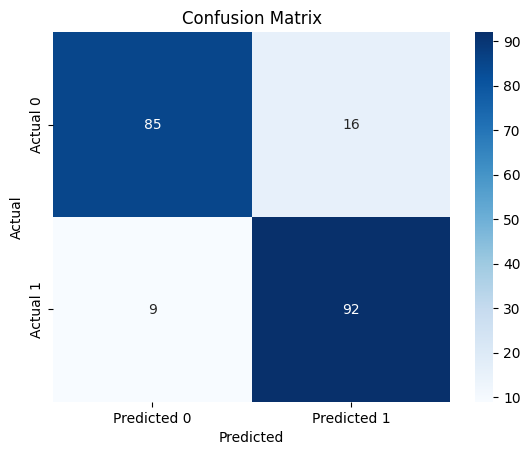

Accuracy: 0.88
Precision: 0.85
Recall: 0.91
F1 Score: 0.88

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.84      0.87       101
     Class 1       0.85      0.91      0.88       101

    accuracy                           0.88       202
   macro avg       0.88      0.88      0.88       202
weighted avg       0.88      0.88      0.88       202



In [225]:
cm = confusion_matrix(y_test, predict_final)
# Calculate all the important metrics
accuracy = accuracy_score(y_test, predict_final)
precision = precision_score(y_test, predict_final)
recall = recall_score(y_test, predict_final)
f1 = f1_score(y_test, predict_final)

# Display the confusion matrix using Seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Optionally, print a full classification report
print("\nClassification Report:")
print(classification_report(y_test, predict_final, target_names=['Class 0', 'Class 1']))